In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import os
import sys
from ocp_table_tpot.globals import Globals as gd
from tpot import TPOTRegressor
sys.path.insert(0,'..')
from src.models.model import HistoricalMedian,XGBoost,LinearModel,RF,KNN,SVM,mase,TimeSeriesSplitImproved
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,RANSACRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from skgarden.quantile import RandomForestQuantileRegressor
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.preprocessing import FunctionTransformer
from copy import copy
from tpot.builtins import StackingEstimator
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import make_pipeline, make_union
from catboost import CatBoostRegressor,Pool,cv
import umap


df_tsfresh = pd.read_pickle(f'../data/processed/train_test_tsfresh_6.pkl').reset_index(level = 0)
data_dict = pd.read_pickle(f'../data/processed/data_dict_all.pkl')


In [12]:
year = 2019
tgt = 'final.output.recovery'
X = data_dict[year]['X_train_tsclean']
y = data_dict[year]['y_train_tsclean']
print(f'1) X shape: {X.shape},y: {y.shape}')


X_test=  data_dict[year]['X_test_ts']
print(f'1) Test shape: {X_test.shape}, train: {X.shape}')

inds_y = y[(y[tgt] > 41) & (y[tgt] < 100)].index
inds_common = inds_y
X = X.loc[inds_common,]

print(f'2) Test shape: {X_test.shape}, train: {X.shape}')

y = y.loc[inds_common, tgt]

#X = X.sample(frac=0.8,random_state=123).sort_index().dropna()
y= y[X.index]
X_filt = X.filter(regex  ="rougher",axis = 1)

Nmonths_total = 8
Nspl = int(Nmonths_total * 30 / 15)
Nmonths_test = 4
Nmonths_min_train = 2.5
train_splits = Nspl // Nmonths_total*Nmonths_min_train
test_splits=int(Nmonths_test / Nmonths_total*Nspl)
cv = TimeSeriesSplitImproved(n_splits=Nspl)

1) X shape: (12573, 332),y: (12573, 7)
1) Test shape: (5856, 332), train: (12573, 332)
2) Test shape: (5856, 332), train: (12392, 332)


# Base models

In [13]:
lasso =
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.01, l1_ratio=.9, random_state=3))
ENetPoly = make_pipeline(RobustScaler(),PolynomialFeatures(), ElasticNet(alpha=0.01, l1_ratio=.9, random_state=3))

RS = make_pipeline(RobustScaler(), RANSACRegressor(random_state = 9))

CatBoost = CatBoostRegressor(loss_function='MAE',random_seed =123,learning_rate=0.1,max_depth=8,task_type='GPU',od_type = 'Iter',od_wait= 15,iterations = 2000)

params_xg =  {'max_depth': 2, 'gamma': '0.544', 'colsample_bytree': '0.684', 'subsample': '0.932'}

model_xgb = xgb.XGBRegressor(learning_rate=0.1,  
                             n_estimators=200,                        
                             random_state =7, nthread = -1,**params_xg)
params_xg_poly =  {'max_depth': 4, 'gamma': '0.544', 'colsample_bytree': '0.684', 'subsample': '0.932'}
model_xgb_poly = make_pipeline(PolynomialFeatures(),RobustScaler(),xgb.XGBRegressor(learning_rate=0.1,  
                             n_estimators=200,                        
                             random_state =7, nthread = -1,**params_xg_poly))


model_lgb = lgb.LGBMRegressor(objective='mae',num_leaves=5,
                              learning_rate=0.15, n_estimators=500,
                              bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9  )
param_grids = {'n_estimators': 1000,
                   'max_features': 0.8, # tuned
                   'max_depth': 14, # tuned
                   }
model_qrf = RandomForestQuantileRegressor(**param_grids,
               criterion = 'mae',
               n_jobs = -1,
                random_state =123)

umap_lgb = make_pipeline(umap.UMAP(n_components = 20),lgb.LGBMRegressor(objective='mae',max_depth=7,
                              learning_rate=0.15, n_estimators=500,
                                    feature_fraction_seed=9  ))

In [14]:
n_folds = 6

def rmsle_cv_gen_compare(model,cv = None,plot = False,X_base=None,X_alt = None,y=None,return_folds = False):
    if cv is None:
        cv = KFold(n_folds, shuffle=False, random_state=42)
    scores = []
    preds_all_alt = np.empty_like(y)
    preds_all_base = np.empty_like(y)
    fold_dfs = []
    true_all =np.empty_like(y)
    if plot:
        fig,ax = plt.subplots(figsize = (20,16),nrows = n_folds)
    for fold_n, (train_index, valid_index) in enumerate(cv.split(X)):
    # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        X_train_alt, X_valid_alt = X_alt.iloc[train_index], X_alt.iloc[valid_index]
        
        print(y.shape)
        # Do the base
        model.fit(X_train.values,y_train.values.reshape(-1,))
        preds  = model.predict(X_valid.values)
        preds_all_base[valid_index] = preds
        score_val = mase(preds,y_valid)
        # Do the alternative
        model.fit(X_train_alt.values,y_train.values.reshape(-1,))
        preds_alt  = model.predict(X_valid_alt.values)
        score_val_alt = mase(preds_alt,y_valid)
        preds_all_alt[valid_index] = preds_alt
        # print(f'Fold {fold_n}. Score: {score_val:.4f}.')
        #print('')
        true_all[valid_index] = y_valid
        scores.append(score_val)
        if plot:
            df = pd.DataFrame({"preds":preds,"true":y_valid,"alter":preds_alt})
            df.plot(ax=ax[fold_n],style =['-o','-o','-o'],title =f'CV score base: {score_val:.4f}, alter: {score_val_alt:.4f}',markersize=2)
        if return_folds:
            fold_data = X_valid
            fold_data['Target'] = y_valid
            fold_data['Pred_base'] = preds
            fold_data['Pred_alt'] = preds_alt
            fold_data['n_fold'] = fold_n

            fold_dfs.append(fold_data)
    
    
    #print(f'CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}.')
    oof_scores = {"base":mase(preds_all_base,true_all),"alter":mase(preds_all_alt,true_all)}
    print(oof_scores)
    if plot:
        return(ax,np.array(scores),oof_scores,fold_dfs)
    elif return_folds:
        return np.array(scores),oof_scores,fold_dfs
    else:
        return np.array(scores),oof_scores
        

def rmsle_cv_gen(model,cv = None,plot = False,X=None,y=None):
    if cv is None:
        cv = KFold(n_folds, shuffle=False, random_state=42)
    scores = []
    if plot:
        fig,ax = plt.subplots(figsize = (13,16),nrows = n_folds)
    for fold_n, (train_index, valid_index) in enumerate(cv.split(X)):
    # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        print(y.shape)
        model.fit(X_train.values,y_train.values.reshape(-1,))
        preds  = model.predict(X_valid.values)
        score_val = mase(preds,y_valid)
        # print(f'Fold {fold_n}. Score: {score_val:.4f}.')
        print('')
        scores.append(score_val)
        if plot:
            df = pd.DataFrame({"preds":preds,"true":y_valid})
            df.plot(ax=ax[fold_n],style =['-o','-o'],title =f'CV score: {score_val:.4f}')
            
    #print(f'CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}.')
    if plot:
        return(ax,np.array(scores))
    else:
        return(np.array(scores))


class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=8):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=False, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                
                instance.fit(np.array(X)[train_index], np.array(y)[train_index])
                y_pred = instance.predict(np.array(X)[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

(12392,)


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(12392,)


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(12392,)


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(12392,)


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(12392,)


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(12392,)


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'base': 2.0305043192455834, 'alter': 1.8746612474991633}


ValueError: too many values to unpack (expected 3)

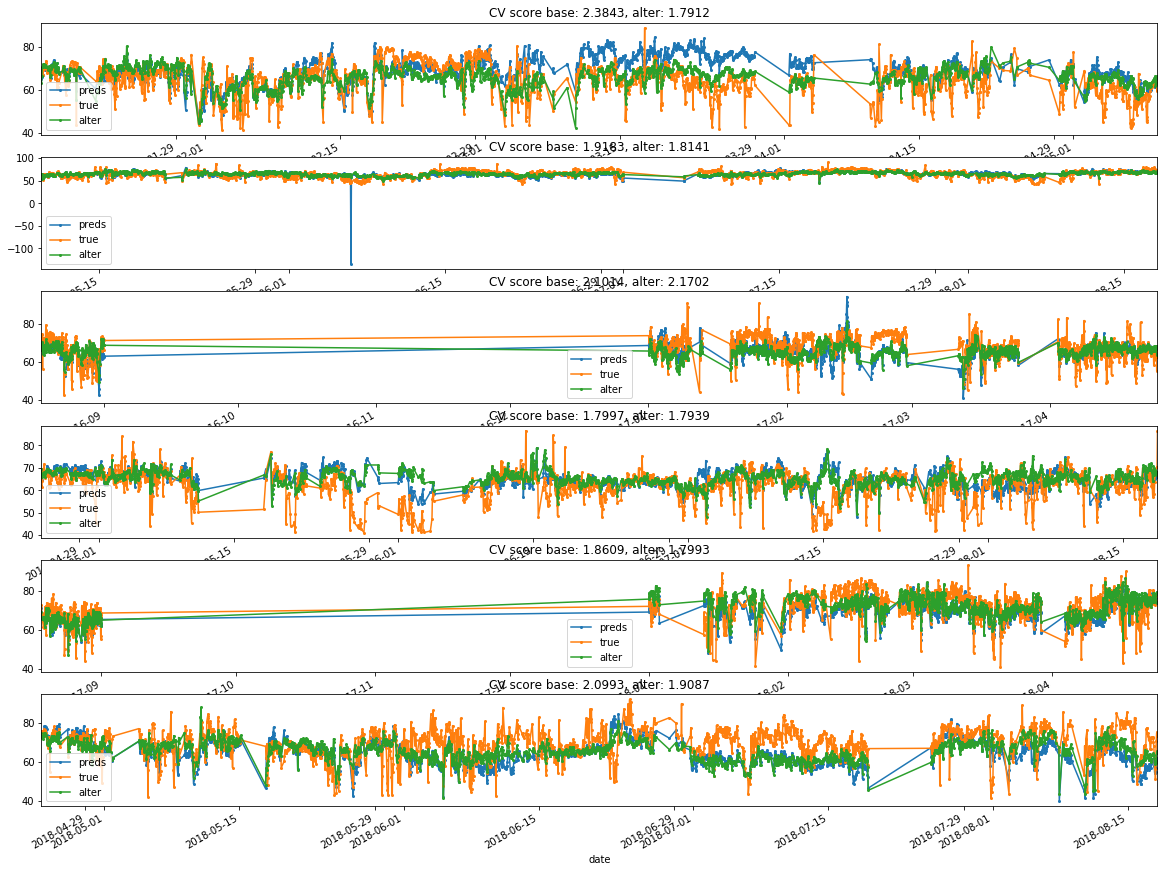

In [15]:
#score = rmsle_cv(lasso)
#print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
ax,score,oof_scores = rmsle_cv_gen_compare(lasso,plot=True,X_base=X,y=y,X_alt = X_filt)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



In [ ]:
ax,score,oof_scores  = rmsle_cv_gen_compare(ENet,plot=True,X_base=X,y=y,X_alt=X_filt)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv_gen(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
ax,score,oof_scores = rmsle_cv_gen_compare(model_xgb,plot=True,X_base=X,X_alt = X_filt,y=y)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


In [ ]:
ax,score,oof_scores  = rmsle_cv_gen_compare(model_lgb,plot=True,X_base=X,y=y,X_alt = X_filt)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv_gen_compare(model_qrf,plot=True,X_base=X,y=y,X_alt = X_filt)
print("QRF score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
pool = Pool(X, y)
params = {'iterations': 300, 
          'loss_function': 'MAE', 
          'verbose': False,
         "random_seed":123,
          "learning_rate":0.5,
          "max_depth":8,
          "task_type":'GPU',
          "od_type" : 'Iter',
          "od_wait": 15
          }
#scores = cv(pool, params)
#print("Catboostmodels score: {:.4f} ({:.4f})".format(scores.mean(), scores.std()))

#scores.tail()

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (model_lgb,model_xgb,lasso),
                                                 meta_model = model_xgb)
ax,score,oof_scores  = rmsle_cv_gen_compare(stacked_averaged_models,plot=True,X_base=X,y=y,X_alt=X_filt)
print("Stacked score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Pull the TPOT models as basic models, attach QRF and do a stacking prediction

In [16]:
xgb_a = xgb.XGBRegressor(learning_rate=0.05,
                            n_estimators=1040,**{'max_depth': 3, 'gamma': '5.034', 'colsample_bytree': '0.409'},
                            silent=1,
                             random_state =7, nthread = -1)

xgb_b = xgb.XGBRegressor(learning_rate=0.05,
                            n_estimators=1040,**{'max_depth': 4, 'gamma': '3.395', 'colsample_bytree': '0.334', 'subsample': '0.182'},
                            silent=1,
                             random_state =8, nthread = -1)
xgb_c = xgb.XGBRegressor(learning_rate=0.05,
                            n_estimators=1040,**{'max_depth': 2, 'gamma': '0.544', 'colsample_bytree': '0.684', 'subsample': '0.932'},
                            silent=1,
                             random_state =9, nthread = -1)
xgb_d = xgb.XGBRegressor(learning_rate=0.05,
                            n_estimators=1040,**{'max_depth': 3, 'gamma': '9.275', 'colsample_bytree': '0.380', 'subsample': '0.948'},
                            silent=1,
                             random_state =10, nthread = -1)
obj = 'huber'
lgb_a = lgb.LGBMRegressor(objective=obj,
                              learning_rate=0.07, n_estimators=500,random_state=7,
                              **{'max_depth': 4, 'num_leaves': 63, 'feature_fraction': '0.89', 'bagging_fraction': '0.757'})
lgb_b = lgb.LGBMRegressor(objective=obj,
                              learning_rate=0.07, n_estimators=500,random_state=8,
                              **{'max_depth': 4, 'num_leaves': 63, 'feature_fraction': '0.879', 'bagging_fraction': '0.727'})
lgb_c = lgb.LGBMRegressor(objective=obj,
                              learning_rate=0.07, n_estimators=500,random_state=9,
                              **{'max_depth': 5, 'num_leaves': 65, 'feature_fraction': '0.879', 'bagging_fraction': '0.727'})
lgb_d = lgb.LGBMRegressor(objective=obj,
                              learning_rate=0.07, n_estimators=500,random_state=10,
                              **{'max_depth': 4, 'num_leaves': 60, 'feature_fraction': '0.797', 'bagging_fraction': '0.982'})
lgb_e = lgb.LGBMRegressor(objective=obj,
                              learning_rate=0.07, n_estimators=500,random_state=12,
                              **{'max_depth': 5, 'num_leaves': 60, 'feature_fraction': '0.8', 'bagging_fraction': '0.92'})
lgb_f = lgb.LGBMRegressor(objective=obj,
                              learning_rate=0.07, n_estimators=500,random_state=123,
                              **{'max_depth': 4, 'num_leaves': 63, 'feature_fraction': '0.89', 'bagging_fraction': '0.757'})
lgb_g = lgb.LGBMRegressor(objective=obj,
                              learning_rate=0.07, n_estimators=500,random_state=321,
                              **{'max_depth': 4, 'num_leaves': 63, 'feature_fraction': '0.85', 'bagging_fraction': '0.737'})
lgb_h = lgb.LGBMRegressor(objective=obj,
                              learning_rate=0.07, n_estimators=500,random_state=231,
                              **{'max_depth': 5, 'num_leaves': 65, 'feature_fraction': '0.8', 'bagging_fraction': '0.7'})
lgb_i = lgb.LGBMRegressor(objective=obj,
                              learning_rate=0.07, n_estimators=500,random_state=1657,
                              **{'max_depth': 4, 'num_leaves': 63, 'feature_fraction': '0.797', 'bagging_fraction': '0.99'})
lgb_j = lgb.LGBMRegressor(objective=obj,
                              learning_rate=0.07, n_estimators=500,random_state=1256,
                              **{'max_depth': 5, 'num_leaves': 65, 'feature_fraction': '0.7', 'bagging_fraction': '0.9'})
# Score 1.290 params {'max_depth': 4, 'num_leaves': 60, 'feature_fraction': '0.797', 'bagging_fraction': '0.982'}

#Score 1.280 params {'max_depth': 5, 'num_leaves': 65, 'feature_fraction': '0.879', 'bagging_fraction': '0.727'}
# Score 1.279 params {'max_depth': 7, 'num_leaves': 6, 'feature_fraction': '0.502', 'bagging_fraction': '0.217'}
#Score 1.269 params {'max_depth': 6, 'num_leaves': 6, 'feature_fraction': '0.650', 'bagging_fraction': '0.291'}




stacked_averaged_models = StackingAveragedModels(base_models = (lgb_a,lgb_b,lgb_c,lgb_d,lgb_e,lgb_f,lgb_g,lgb_h,lgb_i,lgb_j),
                                                 meta_model = lasso)


#,lgb_a,lgb_b,lgb_c,lgb_d),
#ax,score,oof_scores,fold_data  = rmsle_cv_gen_compare(stacked_averaged_models,plot=True,X_base=X,y=y,X_alt=X_filt,return_folds=True)

'alagblagc'

In [36]:
tmp = pd.concat(fold_data)
tmp.to_csv('fold_data.csv')

# Final predictions:



In [27]:
from sklearn.ensemble import IsolationForest
irf = IsolationForest(verbose =1,contamination='auto',behaviour='new')

def clean_target(y,wupper = int(24*10*2.5),wmean =int(24*8/0.4),wlower = int(24*4*2.5),wstd = int(24*30*2.5),upper_std=False ):
    import altair as alt
    alt.data_transformers.enable('default', max_rows=None)

    tmp = pd.DataFrame(y)
    tmp.columns=['Tgt']
    tmp.reset_index(inplace=True)

    tmp['mean'] = tmp['Tgt'].rolling(window = wmean,center=True).median().fillna(method='bfill')
    tmp['std'] = tmp['Tgt'].rolling(window = wstd,center=True).std().fillna(method='bfill')
    #tmp['upper'] = (tmp['mean']+ 1.5 * tmp['std']).fillna(method='bfill').fillna(method='ffill')
    tmp['lower'] = (tmp['mean']- 1.7 * tmp['std']).fillna(method='bfill').fillna(method='ffill')
    #tmp['lower'] = tmp['Tgt'].rolling(window = wlower,center=True).quantile(0.04).fillna(method='bfill')
    tmp['upper'] = tmp['Tgt'].rolling(window = wupper).quantile(0.98).fillna(method='bfill')
    if upper_std:
        tmp['upper'] = (tmp['mean']+ 1.7 * tmp['std']).fillna(method='bfill').fillna(method='ffill')


    tmp_melt = tmp.melt(id_vars = ['date'])
    y = y.loc[tmp[(tmp.Tgt > tmp.lower) & (tmp.Tgt < tmp.upper)].date,]
    
    ch = alt.Chart(width=1000,data = tmp_melt).mark_point(filled=True,size= 5).encode(
                x='date',
                y='value:Q',
                color='variable:N',
                #shape = 'variable',
                opacity=alt.value(0.6))
    
    
    return y,tmp_melt,ch


preds_all = []
model = stacked_averaged_models
for year in [2016,2017]:
    print(year)
    year_train = 2019
    data_dict = pd.read_pickle(f'../data/processed/data_dict_all.pkl')
    X_test = data_dict[year]['X_test_ts'].copy().filter(regex  ="rougher",axis = 1).tz_convert(None)
    tgt = "rougher.output.recovery"
    
    X = data_dict[year_train]['X_train_tsclean'].copy().tz_convert(None)
    # Get the window

    
    print(f'1a) Test shape: {X_test.shape}, train: {X.shape}')
    y = data_dict[year_train]['y_train_tsclean'][tgt].copy().dropna().tz_convert(None)
    y = y[(y>45) & (y <99)]
    #Fit Isolation RF
    #irf.fit(X)
    #irf_preds = irf.predict(X)
   # X= X.loc[irf_preds > 0]
    print(f'1b) Test shape: {X_test.shape}, train: {X.shape} after FILT')
    
    #y,tmp_melt,chrr = clean_target(y,upper_std=True)
   # print(ch)

    inds = X.index.intersection(y.index)
    X = X.loc[inds].filter(regex  ="rougher",axis = 1)
    y = y.loc[inds]
    print(f'1c) Test shape: {X_test.shape}, train: {X.shape} after intersect with Y')

    model.fit(X.values, y)
    ypred_r = model.predict(X_test.values)
    preds_r = pd.DataFrame(data = {'date':X_test.index, tgt:ypred_r}).set_index('date')
    
    tgt = "final.output.recovery"
    
    X = data_dict[year_train]['X_train_tsclean'].copy().tz_convert(None)
    X_test = data_dict[year]['X_test_ts'].copy().tz_convert(None)
    y = data_dict[year_train]['y_train_tsclean'][tgt].copy().dropna().tz_convert(None)
    y = y[(y>35) & (y <97)]
    
    
    inds_l,inds_r = X_test.index.min()-pd.Timedelta('130 days'),X_test.index.max()+pd.Timedelta('130 days')
    
    print(f'2a) Test shape: {X_test.shape}, train: {X.shape}')
    # Data cleaning:
   
   # y,tmp_melt,chf = clean_target(y,wupper =24*10*5,wstd=24*50,upper_std=True)
   # print(ch)
   # irf.fit(X)
   # irf_preds = irf.predict(X)
   # X= X.loc[irf_preds > 0]
    print(f'2b) Test shape: {X_test.shape}, train: {X.shape} after FILT')
    
    inds = X.index.intersection(y.index)
    X = X.loc[inds]
    y = y.loc[inds]
    print(f'2c) Test shape: {X_test.shape}, train: {X.shape} after intersect with Y')
    
    model.fit(X.values, y)
    ypred_f = model.predict(X_test.values)
    preds_f = pd.DataFrame(data = {'date':X_test.index, tgt:ypred_f}).set_index('date')

    preds_all.append(preds_r.join(preds_f))


2016
1a) Test shape: (2928, 175), train: (6238, 332)
1b) Test shape: (2928, 175), train: (6238, 332) after FILT
1c) Test shape: (2928, 175), train: (5437, 175) after intersect with Y
2a) Test shape: (2928, 332), train: (6238, 332)
2b) Test shape: (2928, 332), train: (6238, 332) after FILT
2c) Test shape: (2928, 332), train: (5602, 332) after intersect with Y


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


2017
1a) Test shape: (2928, 175), train: (6238, 332)
1b) Test shape: (2928, 175), train: (6238, 332) after FILT
1c) Test shape: (2928, 175), train: (4873, 175) after intersect with Y


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


2a) Test shape: (2928, 332), train: (6238, 332)
2b) Test shape: (2928, 332), train: (6238, 332) after FILT
2c) Test shape: (2928, 332), train: (5329, 332) after intersect with Y


In [28]:
stacked_preds_sub = pd.concat(preds_all)
stacked_preds_sub = stacked_preds_sub.reset_index()
stacked_preds_sub['date'] = stacked_preds_sub['date'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
stacked_preds_sub.set_index('date',inplace=True)
stacked_preds_sub.drop_duplicates(inplace=True)
stacked_preds_sub.to_csv('../results/stacked_sub_lgb_lasso_base_alldata_tsclean_10lgb_window.csv')

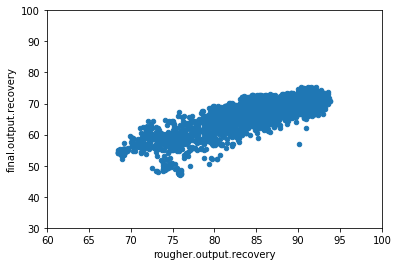

In [29]:
stacked_preds_sub.plot(x='rougher.output.recovery',y='final.output.recovery',xlim=(60,100),ylim=(30,100),kind='scatter')

In [ ]:
ypred_r